In [1]:
import os
import tempfile
from glob import glob
import numpy as np
import nibabel as nib
import torch
import monai
from monai.config import print_config
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.data import DataLoader, CacheDataset, PatchIterd, GridPatchDataset
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, RandRotate90d, 
    EnsureTyped, Resized, SqueezeDimd
)
from monai.inferers import SliceInferer
from monai.metrics import DiceMetric
import matplotlib.pyplot as plt

import glob
monai.utils.set_determinism(seed=0)


In [4]:

# # Create a 2D UNet with randomly initialized weights for testing purposes

# # 3 layer network with down/upsampling by a factor of 2 at each layer with 2-convolution residual units

# net = UNet(
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=1,
#     channels=(4, 8, 16),
#     strides=(2, 2),
#     num_res_units=2,
# )

# # Initialize a dummy 3D tensor volume with shape (N,C,D,H,W)
# input_volume = torch.ones(1, 1, 64, 256, 256)

# # Create an instance of SliceInferer with roi_size as the 256x256 (HxW) and sliding over D axis
# axial_inferer = SliceInferer(roi_size=(256, 256), sw_batch_size=1, cval=-1, progress=True)

# output = axial_inferer(input_volume, net)

# # Output is a 3D volume with 2D slices aggregated
# print("Axial Inferer Output Shape: ", output.shape)
# # Create an instance of SliceInferer with roi_size as the 64x256 (DxW) and sliding over H axis
# coronal_inferer = SliceInferer(
#     roi_size=(64, 256),
#     sw_batch_size=1,
#     spatial_dim=1,  # Spatial dim to slice along is added here
#     cval=-1,
#     progress=True,
# )

# output = coronal_inferer(input_volume, net)

# # Output is a 3D volume with 2D slices aggregated
# print("Coronal Inferer Output Shape: ", output.shape)

In [2]:
data_dir = '/homes/zshahpouri/DLP/ASC-PET-001'
directory = '/homes/zshahpouri/DLP/Practic/LOGTEST'
output_dir = '/homes/zshahpouri/DLP/Practic/OUT'

In [3]:
import math 
train_images = sorted(glob.glob(os.path.join(data_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(data_dir, "MAC", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]


# Calculate split sizes
total_size = len(data_dicts)
train_size = math.floor(total_size * 0.7)
val_size = math.floor(total_size * 0.2)
# The test set gets the remaining data points
test_size = total_size - train_size - val_size

# Split the dataset
train_files = data_dicts[:train_size]
val_files = data_dicts[train_size:(train_size + val_size)]
test_files = data_dicts[(train_size + val_size):]

In [24]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    SpatialPadd, ScaleIntensityd, CenterSpatialCropd, EnsureTyped,
)
# Volume-level preprocessing
train_transforms = Compose([
    LoadImaged(keys=["image", "target"]),
    EnsureChannelFirstd(keys=["image", "target"]),
    Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07), mode= 'bilinear'),
    # SpatialPadd(keys=["image", "target"], spatial_size=[168, 168], mode='constant'),  # Adjust spatial_size as needed
    # CenterSpatialCropd(keys=["image", "target"], roi_size=(168, 168)),  # Ensure uniform size
    EnsureTyped(keys=["image", "target"]),
])
# 3D dataset with preprocessing transforms
volume_ds = monai.data.CacheDataset(data=train_files, transform=train_transforms)
# use batch_size=1 to check the volumes because the input volumes have different shapes
# check_loader = DataLoader(volume_ds, batch_size=1)
# check_data = monai.utils.misc.first(check_loader)
# print("first volume's shape: ", check_data["image"].shape, check_data["target"].shape)

Loading dataset: 100%|██████████| 128/128 [02:48<00:00,  1.32s/it]

first volume's shape:  torch.Size([1, 1, 168, 168, 272]) torch.Size([1, 1, 168, 168, 272])


In [25]:
patch_func = PatchIterd(
    keys=["image", "target"],
    patch_size=(None, None, 1),  # Dynamic first two dimensions, 1 slice
    start_pos=(0, 0, 0)
)

patch_transform = Compose([
    SqueezeDimd(keys=["image", "target"], dim=-1),  # Squeeze the last dim
    # Resized(keys=["image", "target"], spatial_size=[168, 168])  # Resize slices
    SpatialPadd(keys=["image", "target"], spatial_size=[168, 168], mode='constant'),  # Adjust spatial_size as needed
    CenterSpatialCropd(keys=["image", "target"], roi_size=(168, 168)),  # Ensure uniform size
])

patch_ds = monai.data.GridPatchDataset(
    data=volume_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False
)
shuffle_ds = monai.data.ShuffleBuffer(patch_ds, buffer_size=30, seed=0)
train_loader = DataLoader(
    shuffle_ds,
    batch_size=64,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
)
check_data = monai.utils.misc.first(train_loader)
print("first patch's shape: ", check_data["image"].shape, check_data["target"].shape)

first patch's shape:  torch.Size([64, 1, 168, 168]) torch.Size([64, 1, 168, 168])


In [26]:
val_ds = monai.data.Dataset(data=val_files, transform=train_transforms)
val_loader = DataLoader(val_ds, num_workers=1, pin_memory=torch.cuda.is_available())


In [27]:
starting_epoch = 0
decay_epoch = 5
learning_rate = 0.001


class DecayLR:
    def __init__(self, epochs, offset, decay_epochs):
        epoch_flag = epochs - decay_epochs
        assert (epoch_flag > 0), "Decay must start before the training session ends!"
        self.epochs = epochs
        self.offset = offset
        self.decay_epochs = decay_epochs

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_epochs) / (
                self.epochs - self.decay_epochs)
    


In [28]:
import torch
import torch.nn as nn
from monai.networks.nets import UNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), 1e-4)

print('Defining optimizer...')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))



max_epochs = 300
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
train_losses = []
val_losses = []
# Define scheduler
print('Defining scheduler...')
lr_lambda = DecayLR(epochs=max_epochs, offset=0, decay_epochs=decay_epoch).step
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

Defining optimizer...
Defining scheduler...


In [29]:
import os
import datetime
from datetime import datetime


class TrainingLogger:
    def __init__(self, directory):
        self.directory = directory
        self.ensure_directory_exists(self.directory)
        self.log_file = self.create_log_file()

    def ensure_directory_exists(self, directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    def create_log_file(self):
        filename = f"{self.directory}/log_{self.get_date()}.txt"
        return open(filename, "w")

    def get_date(self):

        s = datetime.now()
        date = f"{s.month}_{s.day}_{s.hour}_{s.minute}"
        return date

    def log(self, message):
        print(message)
        self.log_file.write(message + "\n")

    def close(self):
        self.log_file.close()

In [30]:
from monai.inferers import sliding_window_inference, SliceInferer


class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, optimizer, loss_function, scheduler, max_epochs, val_interval, directory, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.scheduler = scheduler  # Add scheduler to the class initialization
        self.max_epochs = max_epochs
        self.val_interval = val_interval
        self.directory = directory
        self.device = device  # Assuming device is passed as a parameter
        self.logger = TrainingLogger(directory)
        self.best_metric = float('inf')
        self.best_metric_epoch = -1


    def log(self):
        self.logger.log(f"train set: {len(train_files)}" )
        self.logger.log(f"validation set: {len(val_files)}")
        self.logger.log(f"max_epochs: {max_epochs}")
        self.logger.log(f"val_interval: {val_interval}")
        self.logger.log(f"model.channels: {model.channels}")


    def train(self):
        for epoch in range(self.max_epochs):
            self.logger.log("-" * 10)
            self.logger.log(f"epoch {epoch + 1}/{self.max_epochs}")

            self.model.train()
            epoch_loss = 0
            step = 0

            for batch_data in self.train_loader:
                step += 1
                inputs, targets = batch_data["image"].to(self.device), batch_data["target"].to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.loss_function(outputs, targets)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                # Inside your training loop
                # self.logger.log(f"{step}, train_loss: {loss.item():.4f}")

            epoch_loss /= step
            self.logger.log(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            # Step the scheduler here, after the training phase and before the validation phase
            self.scheduler.step()
            self.logger.log(f"Stepped scheduler to epoch {epoch + 1}, current lr: {self.scheduler.get_last_lr()}")

            # Validation phase with SliceInferer
            if (epoch + 1) % self.val_interval == 0:
                self.model.eval()
                val_loss = 0
                # Define roi_size based on your model and data specifics
                # Here, considering 2D slice size
                roi_size = (168, 168)
                sw_batch_size = 4  # You can adjust this based on your system's memory
                
                with torch.no_grad():
                    for val_data in val_loader:
                        val_inputs = val_data["image"].to(self.device)
                        val_targets = val_data["target"].to(self.device)
                        slice_inferer = SliceInferer(
                            roi_size=roi_size,
                            sw_batch_size=sw_batch_size,
                            spatial_dim=1,  # Spatial dim to slice along is defined here
                            device=torch.device("cpu"),
                            padding_mode="replicate",
                        )
                        val_outputs = slice_inferer(val_inputs, model).to("cpu")
                        # Compute validation loss
                        val_loss += self.loss_function(val_outputs, val_targets).item()

                val_loss /= len(self.val_loader)
                self.logger.log(f"Validation loss: {val_loss:.4f}")

                if val_loss < self.best_metric:
                    self.best_metric = val_loss
                    self.best_metric_epoch = epoch + 1
                    self.save_model()

        self.logger.close()

    def save_model(self):
        model_filename = f"model_{self.logger.get_date()}.pth"
        torch.save(self.model.state_dict(), os.path.join(self.directory, model_filename))
        self.logger.log(f"Saved {model_filename} model, best_metric: {self.best_metric:.4f}, epoch: {self.best_metric_epoch}")


    
trainer = ModelTrainer(model, train_loader, val_loader, optimizer, loss_function, scheduler, max_epochs, val_interval,directory, device)
trainer.log()
trainer.train()


train set: 128
validation set: 36
max_epochs: 300
val_interval: 2
model.channels: (16, 32, 64, 128)
----------
epoch 1/300


epoch 1 average loss: 0.6591
Stepped scheduler to epoch 1, current lr: [0.001]
----------
epoch 2/300
epoch 2 average loss: 0.4051
Stepped scheduler to epoch 2, current lr: [0.001]
Validation loss: 0.4135
Saved model_2_23_13_43.pth model, best_metric: 0.4135, epoch: 2
----------
epoch 3/300
epoch 3 average loss: 0.3116
Stepped scheduler to epoch 3, current lr: [0.001]
----------
epoch 4/300
epoch 4 average loss: 0.2608
Stepped scheduler to epoch 4, current lr: [0.001]
Validation loss: 0.2773
Saved model_2_23_13_46.pth model, best_metric: 0.2773, epoch: 4
----------
epoch 5/300
epoch 5 average loss: 0.2136
Stepped scheduler to epoch 5, current lr: [0.001]
----------
epoch 6/300
epoch 6 average loss: 0.2126
Stepped scheduler to epoch 6, current lr: [0.0009966101694915254]
Validation loss: 0.2288
Saved model_2_23_13_50.pth model, best_metric: 0.2288, epoch: 6
----------
epoch 7/300
epoch 7 average loss: 0.1674
Stepped scheduler to epoch 7, current lr: [0.0009932203389830508]
----------
ep

image shape: torch.Size([168, 168]), target shape: torch.Size([168, 168])


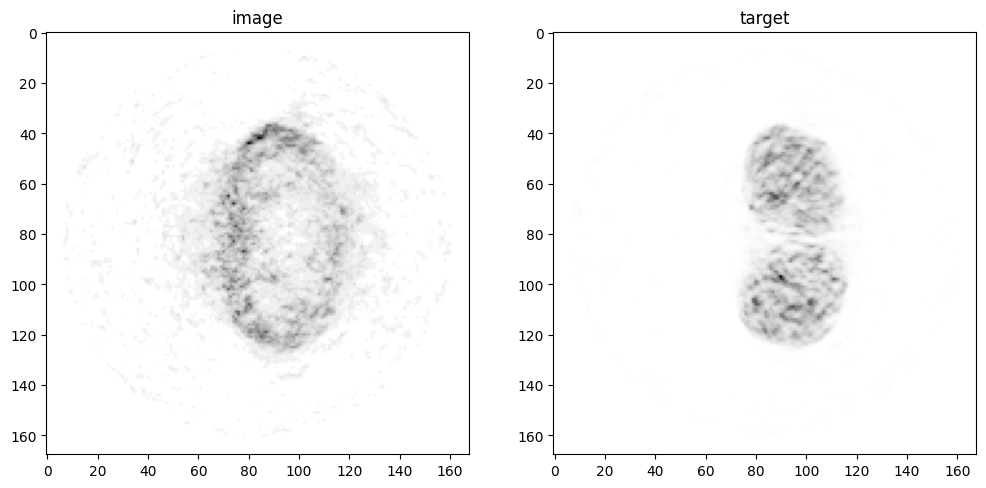

In [20]:
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image, cmap="gist_yarg")  # Adjusted to remove the third dimension indexing
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target, cmap='gist_yarg')  # Adjusted to remove the third dimension indexing
plt.show()


In [32]:
def find_last_saved_model(log_filepath):
    last_saved_model = None
    best_metric = None
    epoch = None
    with open(log_filepath, 'r') as file:
        for line in file:
            if "Saved" in line and ".pth" in line:
                parts = line.split(',')
                last_saved_model = parts[0].split()[1]  # Extract model filename
                best_metric = float(parts[1].split(': ')[1])  # Extract best metric
                epoch = int(parts[2].split(': ')[1])  # Extract epoch number
    return last_saved_model, best_metric, epoch


log_filename = 'log_2_23_13_40.txt'
log_filepath = directory + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_2_23_14_56.pth, Best Metric: 0.206, Epoch: 48


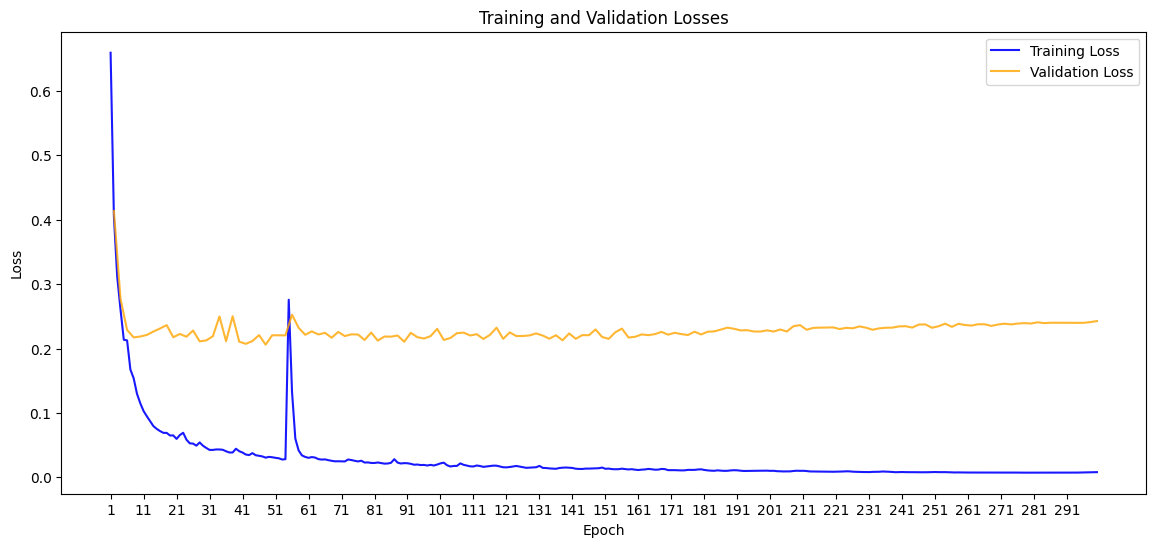

In [37]:

# Function to parse the loss values from the log file
def parse_loss_values(log_filepath):
    train_losses = []
    val_losses = []
    with open(log_filepath, 'r') as file:
        for line in file:
            if 'average loss:' in line:
                loss_value = float(line.split(': ')[-1])
                train_losses.append(loss_value)
            if 'Validation loss:' in line:
                val_loss_value = float(line.split(': ')[-1])
                val_losses.append(val_loss_value)
    return train_losses, val_losses

# Replace this with the path to your actual log file

train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 10))  # Adjust the x-axis ticks if needed
plt.show()


In [34]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(directory, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")

Model file model_2_23_14_56.pth is loading.


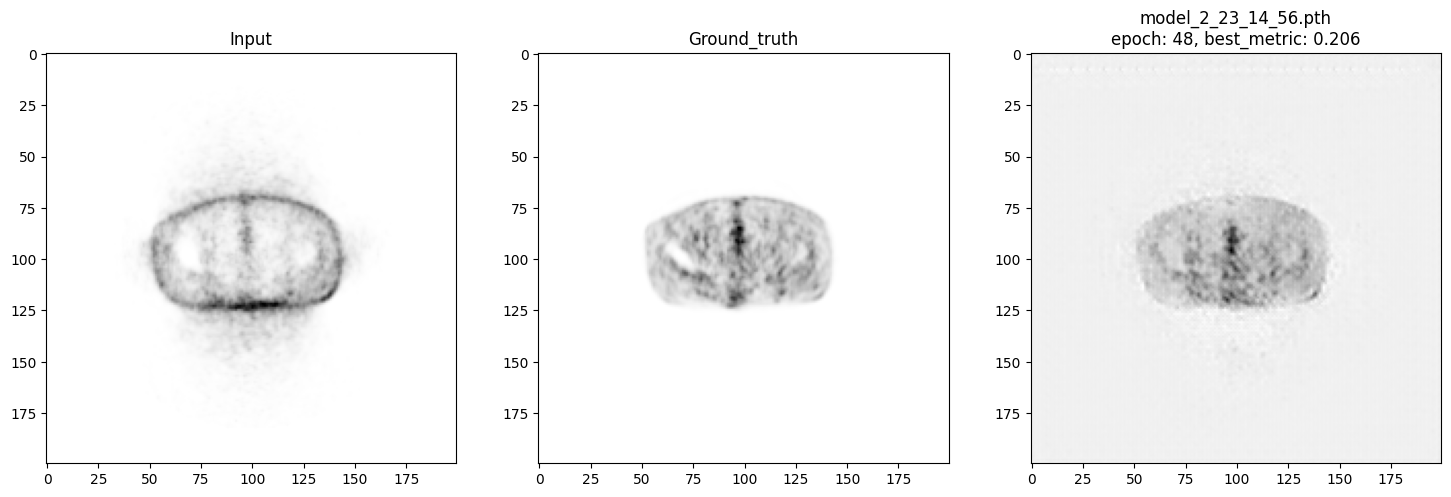

In [35]:
def visualize_results_whole(data, model, title):
    model.eval()
    # Select a middle slice or any specific slice from the volume
    # slice_idx = data["image"].shape[-1] // 2  # Example for selecting the middle slice
    slice_idx = 50

    with torch.no_grad():
        # Ensure the input is 4D: [batch_size, channels, height, width]
        # Adjust dimensions as needed, e.g., selecting the middle slice
        input_2d = data["image"][..., slice_idx].to(device)  # Adjust indexing if necessary
        model_outputs = model(input_2d)

    plt.figure("check", (18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Input")
    # Adjust the slice selection accordingly
    input_slice = input_2d[0, 0, :, :].cpu().numpy()
    plt.imshow(np.rot90(input_slice), cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title("Ground_truth")
    # Adjust the slice selection accordingly
    target_slice = data["target"][..., slice_idx][0, 0, :, :].cpu().numpy()
    plt.imshow(np.rot90(target_slice), cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    # Assuming model outputs are [batch_size, channels, height, width]
    output_slice = model_outputs[0, 0, :, :].detach().cpu().numpy()
    plt.imshow(np.rot90(output_slice), cmap="gist_yarg")

    plt.show()



with torch.no_grad():
    for i, data in enumerate(val_loader):
        visualize_results_whole(data, model, f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}")
        if i == 0:
            break


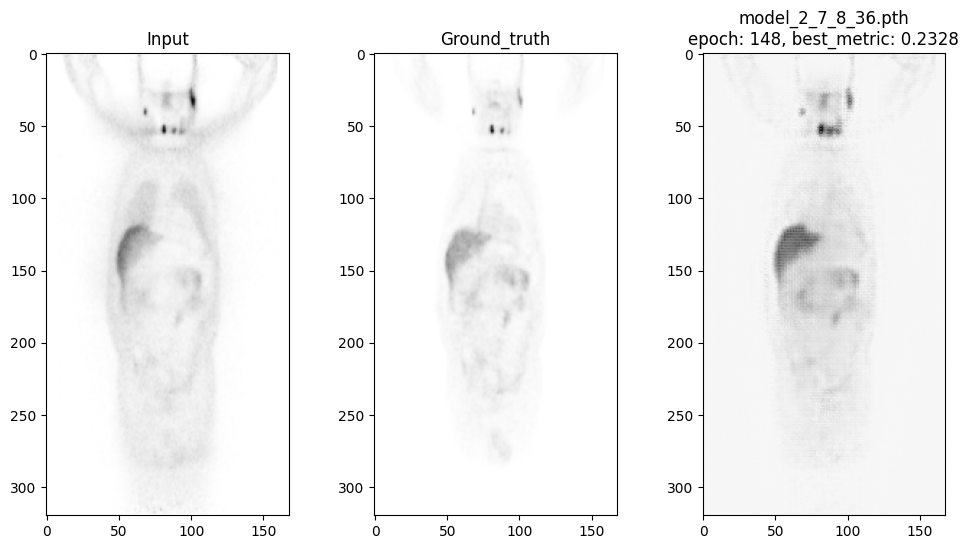

In [26]:
# with torch.no_grad():
#     for i, data in enumerate(test_loader):
#         n = 70
#         visualize_results_whole(data, model, n, f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}")
#         if i == 2:
#             break

100%|██████████| 31/31 [01:14<00:00,  2.41s/it]


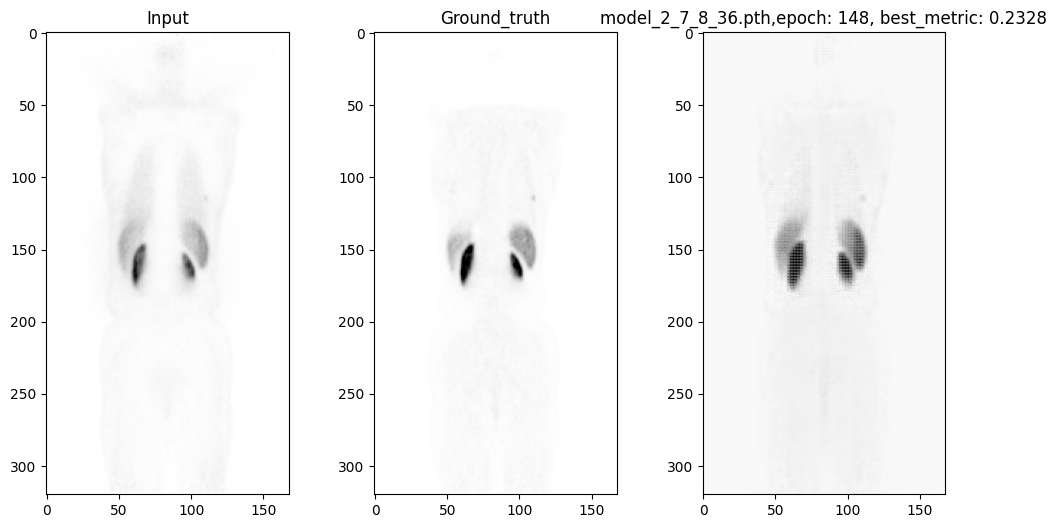

In [27]:
# # Define a function for visualization
# def visualize_results(val_data, model, n, title):

#     val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
#                           sw_batch_size, model, progress=True, overlap=0.70) # using ov= 0.9 best image ever I have.


#     plt.figure("check", (12, 6))

#     plt.subplot(1, 3, 1)
#     plt.title(f"Input")
#     input_slice = np.rot90(val_data["image"][0, 0, :, n, :])
#     plt.imshow(input_slice, cmap="gist_yarg")

#     plt.subplot(1, 3, 2)
#     plt.title(f"Ground_truth")
#     target_slice = np.rot90(val_data["target"][0, 0, :, n, :])
#     plt.imshow(target_slice, cmap="gist_yarg")

#     plt.subplot(1, 3, 3)
#     plt.title(title)
#     output_slice = np.rot90(val_outputs.detach().cpu()[0, 0, :, n, :])
#     plt.imshow(output_slice, cmap="gist_yarg")
    
#     plt.show()


# roi_size = (80, 80, 80)
# sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
# with torch.no_grad():
#     for i, val_data in enumerate(test_loader):

#         n = 100
#         visualize_results(val_data, model, n, f"{bestmodel_filename},epoch: { best_epoch}, best_metric: {best_metric}")
#         if i == 0:
#             break


